# Analytics Silver: Validação dos Dados Limpos

Neste notebook, conectamos diretamente ao Banco de Dados PostgreSQL para analisar a tabela `imoveis_silver`.
O objetivo é confirmar que as regras de ETL funcionaram:
1.  **Tradução:** As colunas devem estar em Português.
2.  **Limpeza:** Não deve haver outliers extremos (bilhões de dólares ou casas de 1 metro).
3.  **Segmentação:** Continuamos comparando Mercado Padrão (< R$ 1M) vs. Mercado de Luxo (>= R$ 1M).

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sqlalchemy import create_engine, text
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap

# --- 1. CONFIGURAÇÕES VISUAIS ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

def format_currency(x, pos):
    if x >= 1e6: return 'R${:1.1f}M'.format(x*1e-6)
    return 'R${:1.0f}k'.format(x*1e-3)

# --- 2. CONEXÃO COM O BANCO ---
db_host = os.getenv("DB_HOST", "localhost")
db_port = os.getenv("DB_PORT", "5432")
db_name = "imobiliaria_db"
db_user = "postgres"
db_pass = "admin"

db_url = f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}"

print(f"🔌 Conectando ao banco: {db_name} em {db_host}...")

try:
    engine = create_engine(db_url)
    # Lendo a tabela Silver inteira
    query = "SELECT * FROM imoveis_silver"
    df_silver = pd.read_sql(query, engine)
    
    print(f"✅ Dados carregados com sucesso!")
    print(f"📊 Total de registros na Silver: {len(df_silver)}")
    print(f"📋 Colunas (PT-BR): {list(df_silver.columns)}")

    # --- 3. SEGMENTAÇÃO (PADRÃO vs LUXO) ---
    # Nota: Agora usamos a coluna 'preco' em vez de 'price'
    df_padrao = df_silver[df_silver['preco'] < 1000000].copy()
    df_luxo   = df_silver[df_silver['preco'] >= 1000000].copy()

    print("-" * 40)
    print(f"📉 Mercado Padrão (< R$1M): {len(df_padrao)} registros")
    print(f"📈 Mercado Luxo (>= R$1M):  {len(df_luxo)} registros")
    print("-" * 40)
    
except Exception as e:
    print(f"❌ Erro ao conectar no banco: {e}")

🔌 Conectando ao banco: imobiliaria_db em localhost...
✅ Dados carregados com sucesso!
📊 Total de registros na Silver: 907150
📋 Colunas (PT-BR): ['imobiliaria', 'preco', 'quartos', 'banheiros', 'area_terreno', 'rua', 'cidade', 'estado', 'cep', 'area_construida']
----------------------------------------
📉 Mercado Padrão (< R$1M): 810151 registros
📈 Mercado Luxo (>= R$1M):  96999 registros
----------------------------------------


## 1. Localização (Cidades)
Análise das cidades com maior volume de anúncios. Esperamos ver nomes formatados corretamente (Title Case).

C:\Users\julii\AppData\Local\Temp\ipykernel_1460\3508232765.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities_p.values, y=top_cities_p.index, palette='Greens_r')


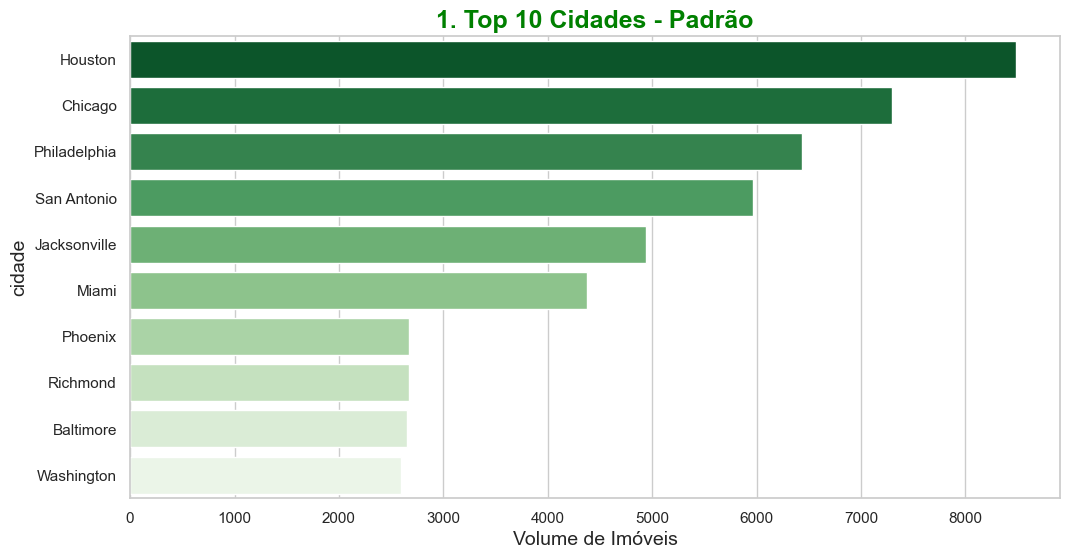

In [46]:
# --- GRÁFICO 1: Top Cidades (MERCADO PADRÃO) ---
plt.figure(figsize=(12, 6))
top_cities_p = df_padrao['cidade'].value_counts().head(10)

sns.barplot(x=top_cities_p.values, y=top_cities_p.index, palette='Greens_r')
plt.title('1. Top 10 Cidades - Padrão', fontweight='bold', color='green')
plt.xlabel('Volume de Imóveis')
plt.show()

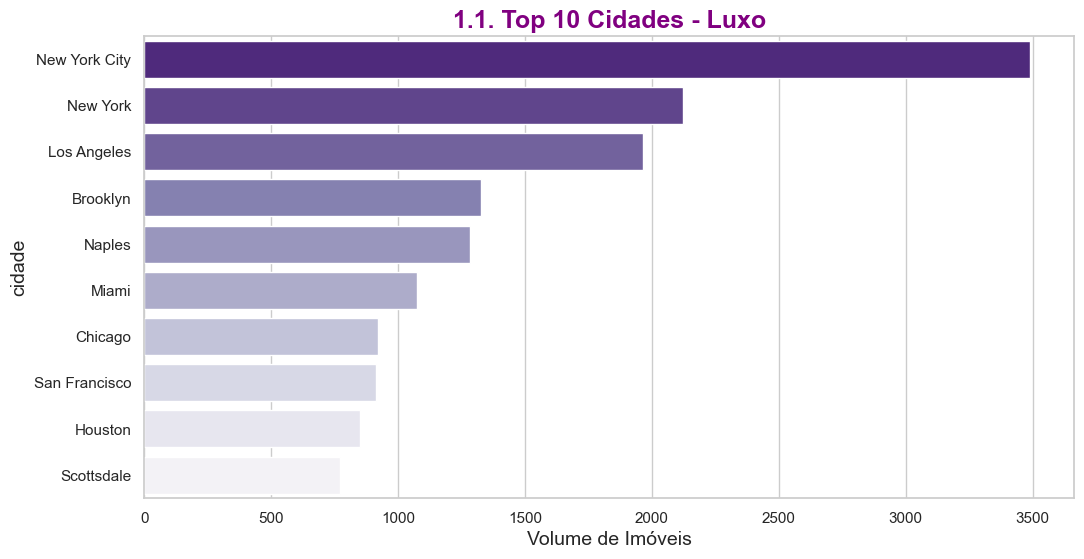

In [47]:
# --- GRÁFICO 1.1: Top Cidades (MERCADO DE LUXO) ---
plt.figure(figsize=(12, 6))

# Na Silver, usamos 'cidade'
top_cities_l = df_luxo['cidade'].value_counts().head(10)

# Correção: Adicionado 'hue', 'legend=False' e '_ ='
_ = sns.barplot(
    x=top_cities_l.values, 
    y=top_cities_l.index, 
    hue=top_cities_l.index,  # Define a cor pela cidade
    palette='Purples_r', 
    legend=False             # Remove a legenda
)

plt.title('1.1. Top 10 Cidades - Luxo', fontweight='bold', color='purple')
plt.xlabel('Volume de Imóveis')
plt.show()

## 2. Distribuição de Preços
Aqui validamos se a limpeza de outliers funcionou. 
* Não devemos ver valores negativos ou próximos de zero.
* A curva deve ser mais "suave" do que no Raw.

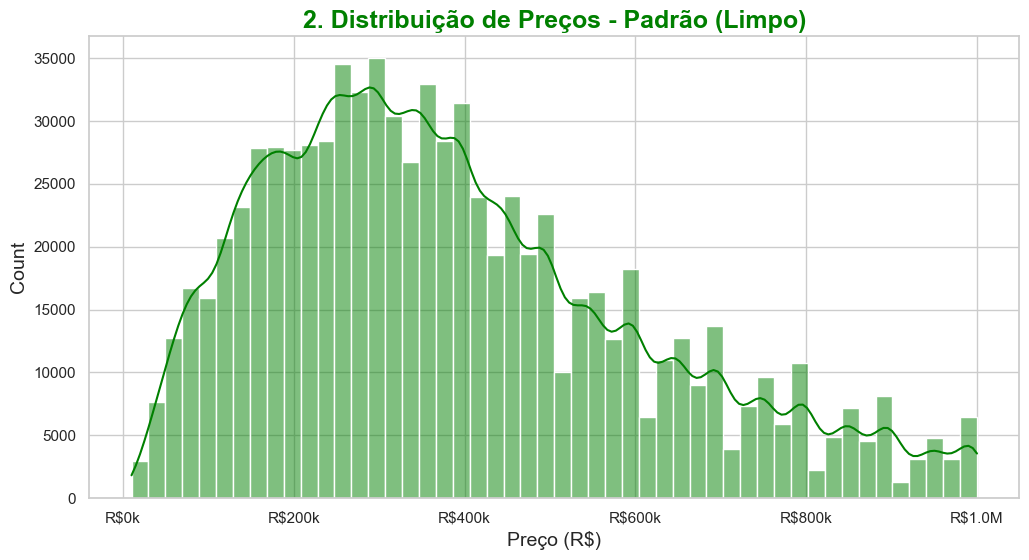

In [48]:
# --- GRÁFICO 2: Distribuição de Preços (PADRÃO) ---
plt.figure(figsize=(12, 6))
sns.histplot(data=df_padrao, x='preco', kde=True, color='green', bins=50)
plt.title('2. Distribuição de Preços - Padrão (Limpo)', fontweight='bold', color='green')
plt.xlabel('Preço (R$)')
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(format_currency))
plt.show()

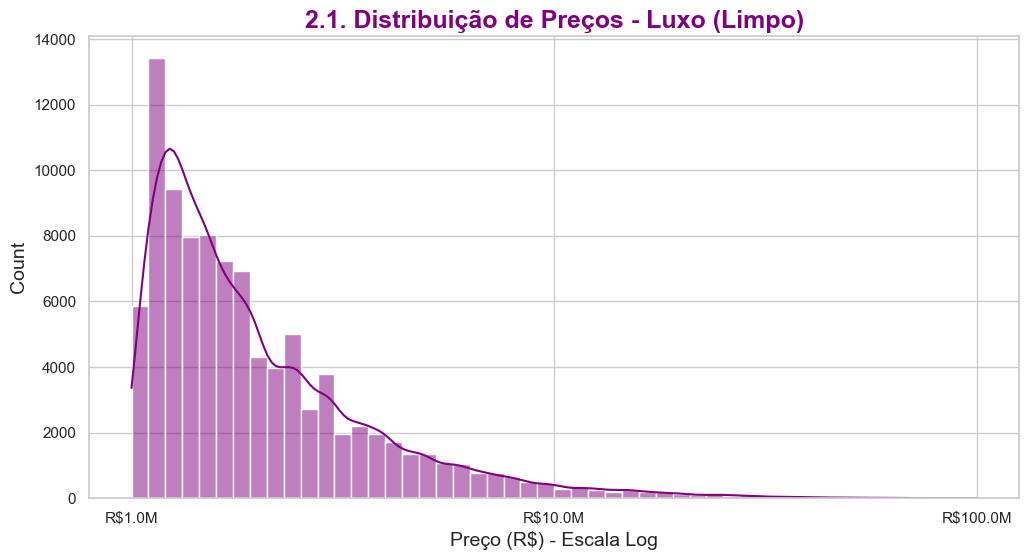

In [49]:
# --- GRÁFICO 2.1: Distribuição de Preços (LUXO) ---
plt.figure(figsize=(12, 6))
# Log scale ainda ajuda no luxo, mas agora sem os bilhões falsos
sns.histplot(data=df_luxo, x='preco', kde=True, color='purple', bins=50, log_scale=True)
plt.title('2.1. Distribuição de Preços - Luxo (Limpo)', fontweight='bold', color='purple')
plt.xlabel('Preço (R$) - Escala Log')
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(format_currency))
plt.show()

## 3. Correlação: Tamanho vs. Preço
Validamos a coluna `area_construida` (antiga `house_size`).
* Esperamos ver uma correlação positiva clara (quanto maior a casa, maior o preço).
* Não devem existir casas de 0m² ou 1m².

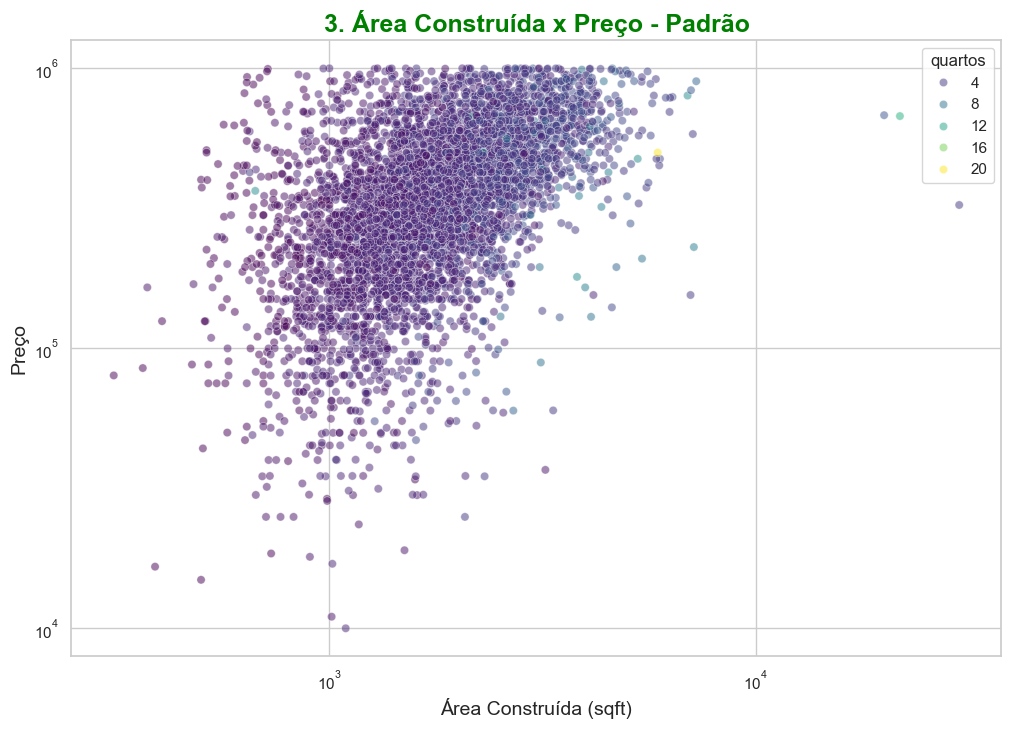

In [50]:
# --- GRÁFICO 3: Tamanho x Preço (PADRÃO) ---
plt.figure(figsize=(12, 8))
# Amostra para performance
subset_p = df_padrao.sample(min(5000, len(df_padrao)))

sns.scatterplot(data=subset_p, x='area_construida', y='preco', hue='quartos', palette='viridis', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('3. Área Construída x Preço - Padrão', fontweight='bold', color='green')
plt.xlabel('Área Construída (sqft)')
plt.ylabel('Preço')
plt.show()

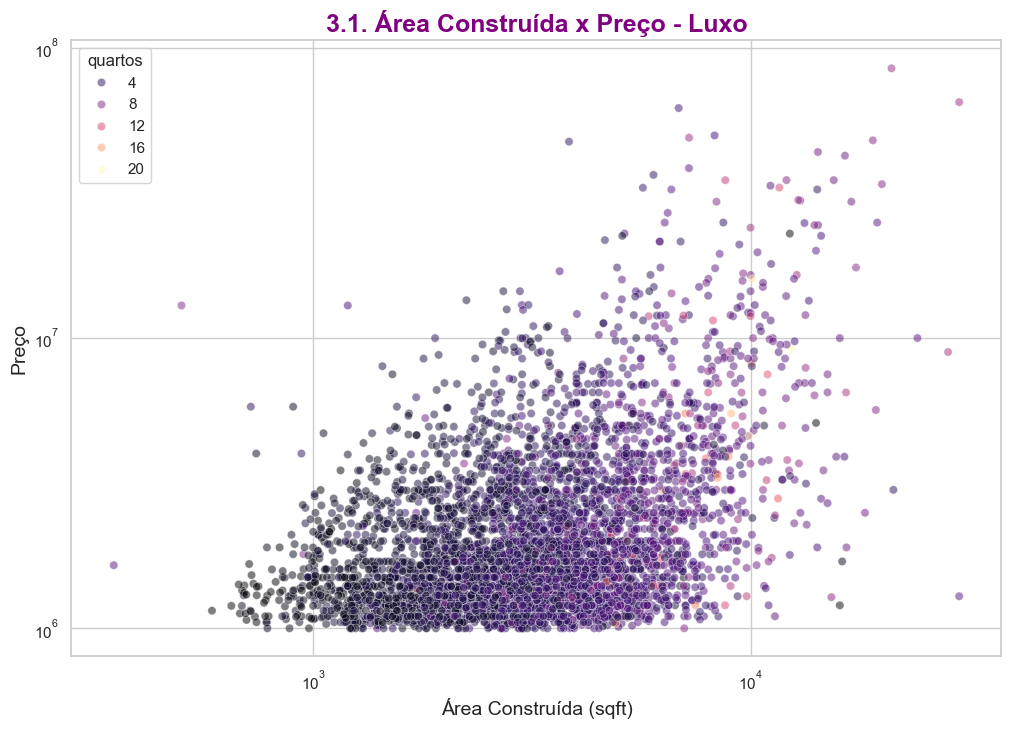

In [51]:
# --- GRÁFICO 3.1: Tamanho x Preço (LUXO) ---
plt.figure(figsize=(12, 8))
subset_l = df_luxo.sample(min(5000, len(df_luxo)))

sns.scatterplot(data=subset_l, x='area_construida', y='preco', hue='quartos', palette='magma', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('3.1. Área Construída x Preço - Luxo', fontweight='bold', color='purple')
plt.xlabel('Área Construída (sqft)')
plt.ylabel('Preço')
plt.show()

## 4. Valorização por Estado
Visualização dos estados mais caros (mediana de preço).

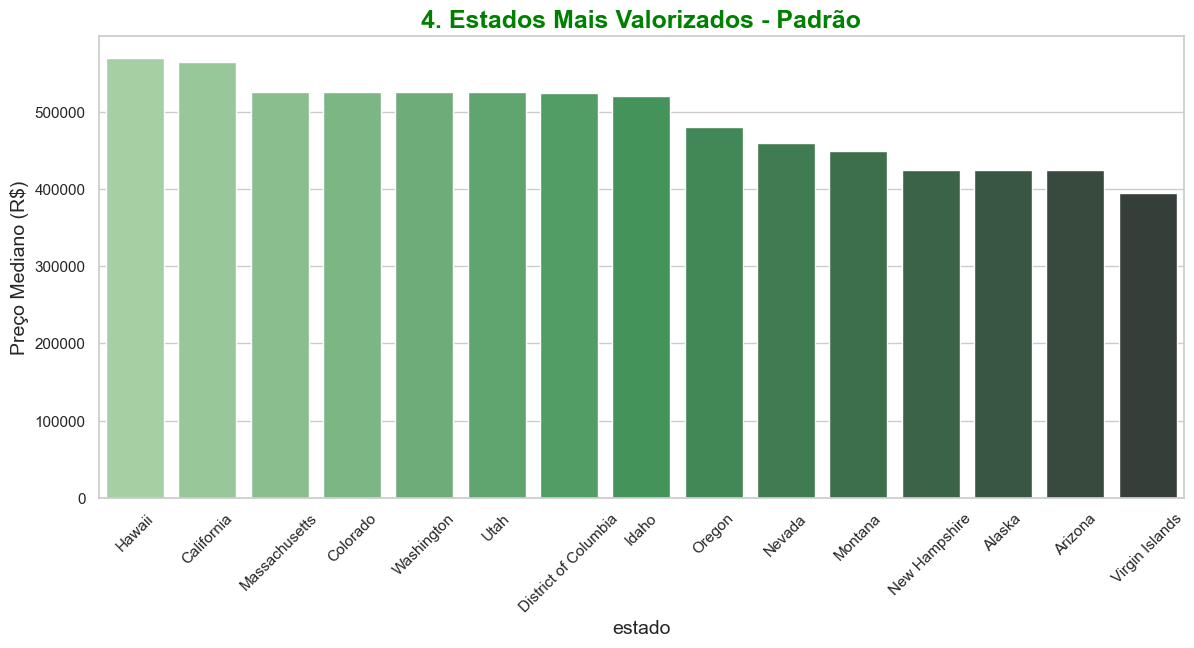

In [52]:
# --- GRÁFICO 4: Estados Mais Valorizados (MERCADO PADRÃO) ---
plt.figure(figsize=(14, 6))

# Agrupa por estado e pega a mediana do preço
state_price_p = df_padrao.groupby('estado')['preco'].median().sort_values(ascending=False).head(15)

_ = sns.barplot(
    x=state_price_p.index, 
    y=state_price_p.values, 
    hue=state_price_p.index, # Define a cor pelo estado
    palette='Greens_d', 
    legend=False
)

plt.title('4. Estados Mais Valorizados - Padrão', fontweight='bold', color='green')
plt.xticks(rotation=45)
plt.ylabel('Preço Mediano (R$)')
plt.show()



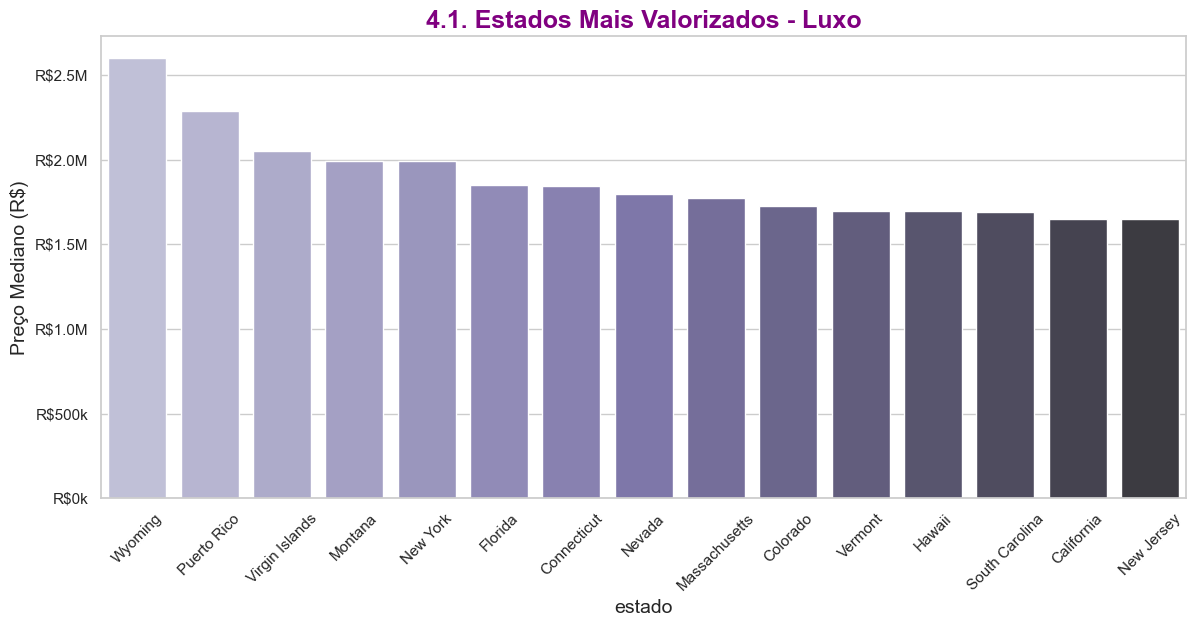

In [53]:
# --- GRÁFICO 4.1: Estados Mais Valorizados (MERCADO DE LUXO) ---
plt.figure(figsize=(14, 6))

state_price_l = df_luxo.groupby('estado')['preco'].median().sort_values(ascending=False).head(15)

_ = sns.barplot(
    x=state_price_l.index, 
    y=state_price_l.values, 
    hue=state_price_l.index,
    palette='Purples_d', 
    legend=False
)

plt.title('4.1. Estados Mais Valorizados - Luxo', fontweight='bold', color='purple')
plt.xticks(rotation=45)
plt.ylabel('Preço Mediano (R$)')

# Formatação de Moeda no Eixo Y (Milhões)
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_currency))

plt.show()

## 5. Estrutura (Quartos)
Validamos se a regra de "Max 20 quartos" funcionou. O eixo X não deve ir até 100 como no Raw.

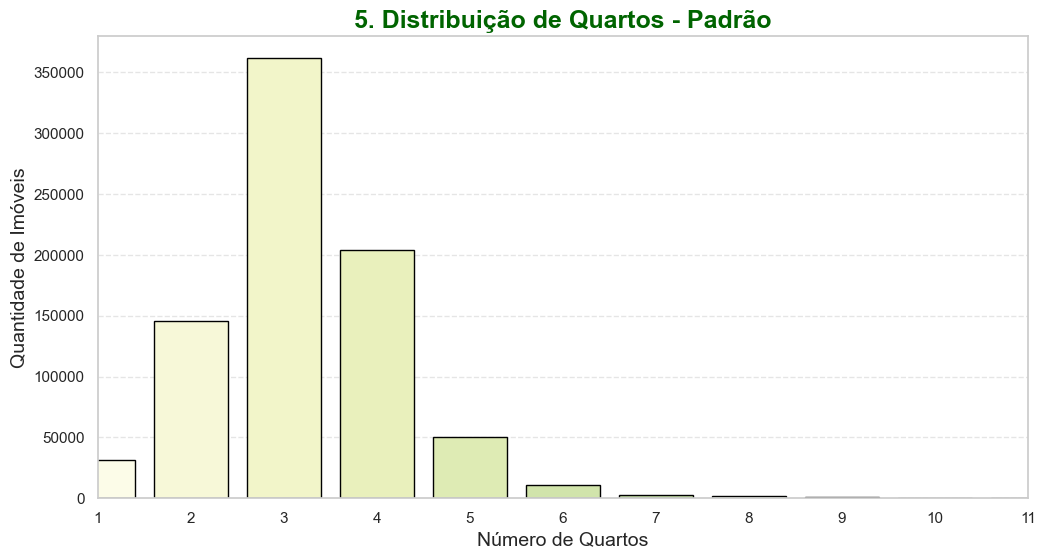

In [54]:
# --- GRÁFICO 5: Distribuição de Quartos (MERCADO PADRÃO) ---
plt.figure(figsize=(12, 6))

# Palette 'YlGn' (Yellow-Green) é mais vibrante que 'Greens'
# edgecolor='black' desenha uma borda nas barras para destacar
_ = sns.countplot(
    x='quartos', 
    data=df_padrao, 
    hue='quartos',    
    palette='YlGn',   # <--- Paleta Melhorada (Verde/Amarelo)
    edgecolor='black',# <--- Borda para definição
    legend=False
)

plt.title('5. Distribuição de Quartos - Padrão', fontweight='bold', color='darkgreen')
plt.xlabel('Número de Quartos')
plt.ylabel('Quantidade de Imóveis')
plt.xlim(0, 10) 
plt.grid(axis='y', linestyle='--', alpha=0.5) # Grid leve apenas horizontal
plt.show()

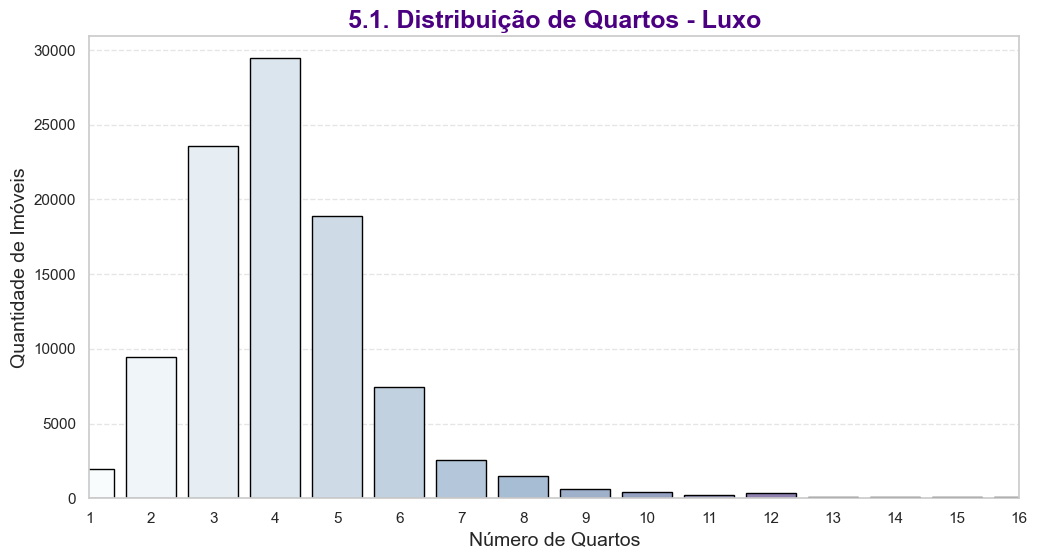

In [55]:
# --- GRÁFICO 5.1: Distribuição de Quartos (MERCADO DE LUXO) ---
plt.figure(figsize=(12, 6))

# Palette 'BuPu' (Blue-Purple) ou 'magma_r' são ótimas para luxo
_ = sns.countplot(
    x='quartos', 
    data=df_luxo, 
    hue='quartos',
    palette='BuPu',   # <--- Paleta Melhorada (Azul/Roxo)
    edgecolor='black',
    legend=False
)

plt.title('5.1. Distribuição de Quartos - Luxo', fontweight='bold', color='indigo')
plt.xlabel('Número de Quartos')
plt.ylabel('Quantidade de Imóveis')
plt.xlim(0, 15) 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 6. Terrenos (Área Externa)
Validamos a coluna `area_terreno` (antiga `acre_lot`).
Lembre-se: no ETL transformamos Nulos em 0.0 (Apartamentos).

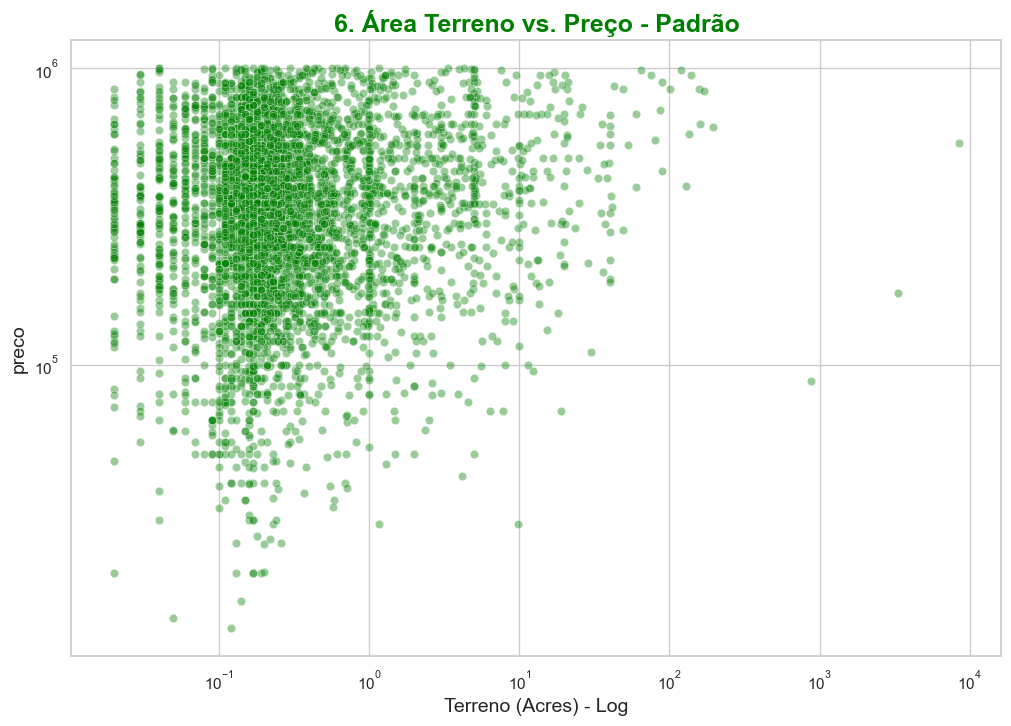

In [56]:
# --- GRÁFICO 6: Terreno (PADRÃO) ---
plt.figure(figsize=(12, 8))
# Filtra > 0.01 para não pegar apartamentos (que são 0)
subset_lot_p = df_padrao[df_padrao['area_terreno'] > 0.01].sample(min(5000, len(df_padrao)))
sns.scatterplot(data=subset_lot_p, x='area_terreno', y='preco', color='green', alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.title('6. Área Terreno vs. Preço - Padrão', fontweight='bold', color='green')
plt.xlabel('Terreno (Acres) - Log')
plt.show()

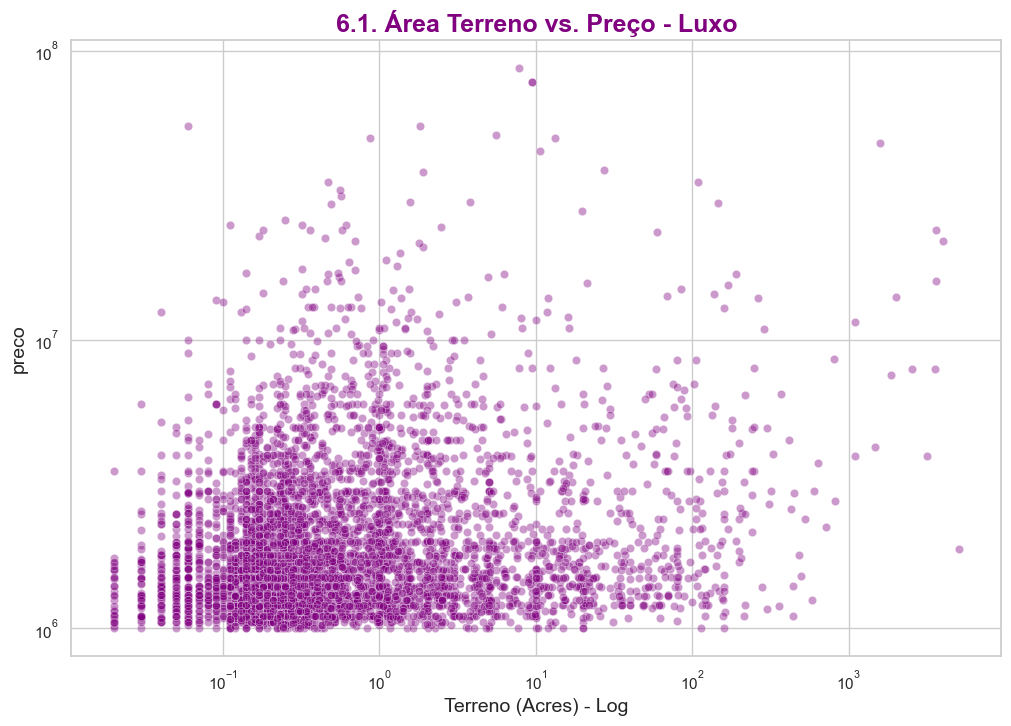

In [57]:
# --- GRÁFICO 6.1: Terreno (LUXO) ---
plt.figure(figsize=(12, 8))
subset_lot_l = df_luxo[df_luxo['area_terreno'] > 0.01].sample(min(5000, len(df_luxo)))
sns.scatterplot(data=subset_lot_l, x='area_terreno', y='preco', color='purple', alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.title('6.1. Área Terreno vs. Preço - Luxo', fontweight='bold', color='purple')
plt.xlabel('Terreno (Acres) - Log')
plt.show()

## 7. Detalhes de Localização: Ruas e Condomínios
Aqui analisamos a coluna `rua`.
* **Expectativa:** No mercado de luxo, nomes de ruas que se repetem muito geralmente indicam condomínios de alto padrão ou prédios de luxo com várias unidades à venda.

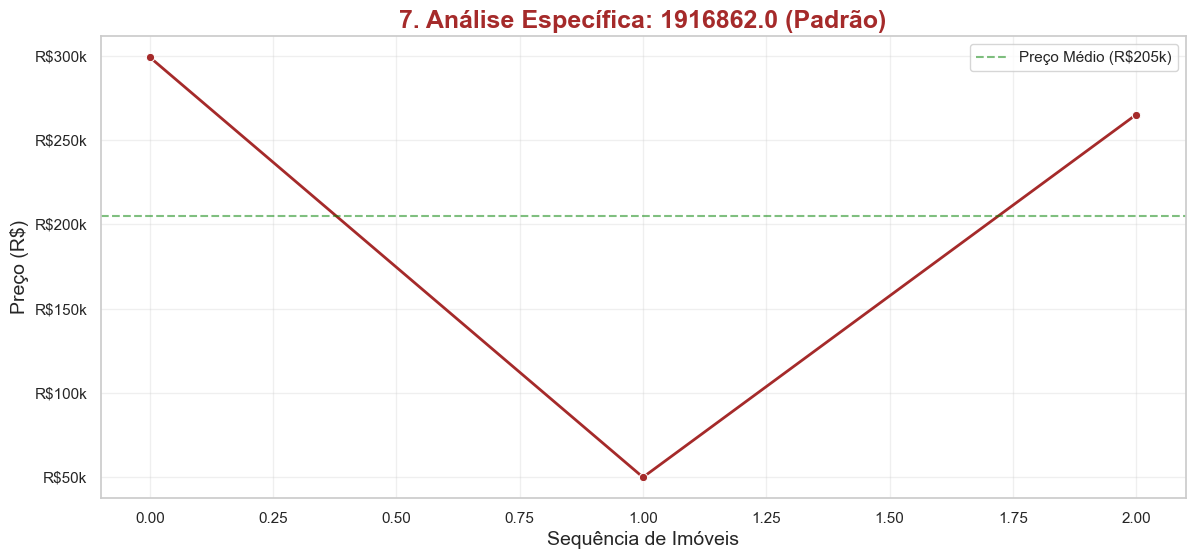

In [58]:
# --- GRÁFICO 7: Variância de Preço - Foco Específico (MERCADO PADRÃO) ---
if 'rua' in df_padrao.columns and 'preco' in df_padrao.columns:
    plt.figure(figsize=(14, 6))
    
    # 1. DEFINIÇÃO MANUAL DO ALVO
    # Em vez de pegar o mais comum, pegamos o que você pediu:
    target_rua = '1916862.0'
    
    # 2. Filtra os dados apenas desse ID
    df_top_p = df_padrao[df_padrao['rua'] == target_rua].copy()
    
    # Verifica se encontrou dados antes de plotar
    if len(df_top_p) > 0:
        # 3. Cria o Eixo X (Sequência)
        df_top_p['sequencia'] = range(len(df_top_p))
        
        # 4. Plotagem
        sns.lineplot(data=df_top_p, x='sequencia', y='preco', marker='o', color='brown', linewidth=2)
        
        # Linha de Média
        media_p = df_top_p['preco'].mean()
        plt.axhline(media_p, color='green', linestyle='--', alpha=0.5, label=f'Preço Médio ({format_currency(media_p, None)})')
        
        plt.title(f'7. Análise Específica: {target_rua} (Padrão)', fontweight='bold', color='brown')
        plt.xlabel('Sequência de Imóveis')
        plt.ylabel('Preço (R$)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Formata eixo Y
        ax = plt.gca()
        ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
        plt.show()
        
    else:
        print(f"⚠️ Aviso: Não foram encontrados registros para a rua/ID '{target_rua}' no Mercado Padrão.")
        print("Dica: Verifique se esse ID pertence ao Mercado de Luxo ou se está escrito exatamente assim.")

In [59]:
# --- GRÁFICO 7.1: Variância de Preço - Foco Específico (MERCADO DE LUXO) ---
if 'rua' in df_luxo.columns and 'preco' in df_luxo.columns:
    plt.figure(figsize=(14, 6))
    
    # 1. DEFINIÇÃO MANUAL DO ALVO
    target_rua_l = '636204.0'
    
    # 2. Filtra os dados apenas desse ID
    df_top_l = df_luxo[df_luxo['rua'] == target_rua_l].copy()
    
    # Verifica se encontrou dados
    if len(df_top_l) > 0:
        # 3. Sequência
        df_top_l['sequencia'] = range(len(df_top_l))
        
        # 4. Plotagem
        sns.lineplot(data=df_top_l, x='sequencia', y='preco', marker='o', color='darkred', linewidth=2)
        
        # Média
        media_l = df_top_l['preco'].mean()
        plt.axhline(media_l, color='purple', linestyle='--', alpha=0.5, label=f'Preço Médio ({format_currency(media_l, None)})')
        
        plt.title(f'7.1. Análise Específica: {target_rua_l} (Luxo)', fontweight='bold', color='darkred')
        plt.xlabel('Sequência de Imóveis')
        plt.ylabel('Preço (R$)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        ax = plt.gca()
        ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
        plt.show()
    
    else:
        print(f"⚠️ Aviso: Não foram encontrados registros para o ID '{target_rua_l}' no Mercado de Luxo.")
        print("Dica: Se ele apareceu no gráfico anterior (Padrão), ele não aparecerá aqui, pois cada imóvel pertence a apenas um grupo.")

⚠️ Aviso: Não foram encontrados registros para o ID '636204.0' no Mercado de Luxo.
Dica: Se ele apareceu no gráfico anterior (Padrão), ele não aparecerá aqui, pois cada imóvel pertence a apenas um grupo.


<Figure size 1400x600 with 0 Axes>

## 8. Densidade de Valor (Preço por Área)
Esta métrica (`preco / area_construida`) é a favorita dos investidores.
* Ela mostra o quanto o m² está valorizado, independente do tamanho da casa.
* **Luxo:** Esperamos ver uma densidade muito maior (materiais nobres).

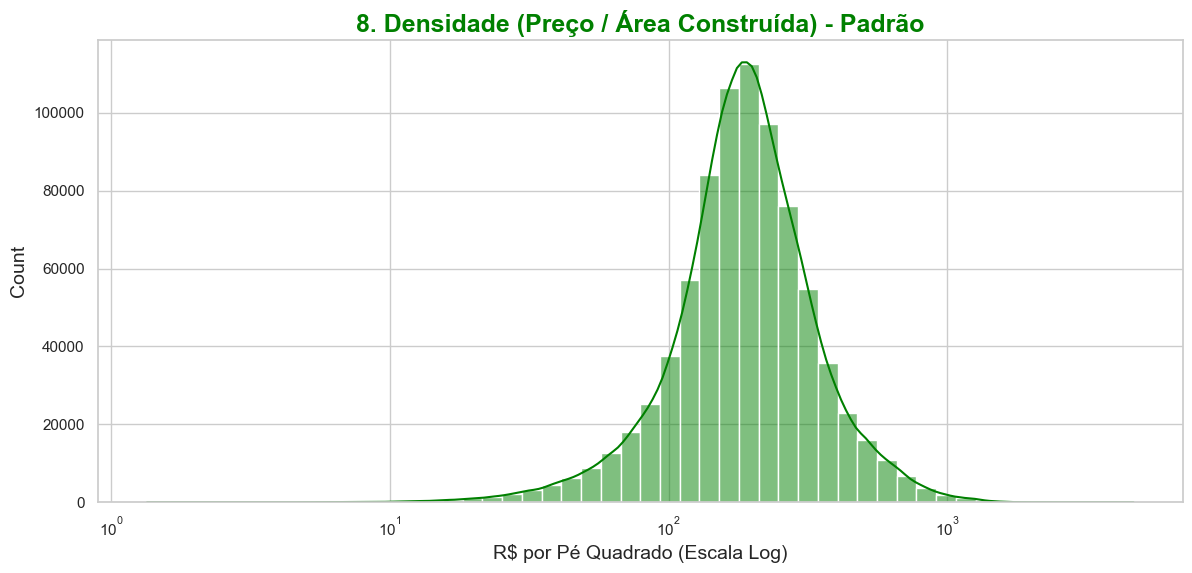

In [60]:
# --- GRÁFICO 8: Preço por Área (PADRÃO) ---
plt.figure(figsize=(14, 6))
# Evita divisão por zero
mask_p = df_padrao['area_construida'] > 0
pp_sqft_p = df_padrao.loc[mask_p, 'preco'] / df_padrao.loc[mask_p, 'area_construida']

sns.histplot(pp_sqft_p, bins=50, log_scale=True, color='green', kde=True)
plt.title('8. Densidade (Preço / Área Construída) - Padrão', fontweight='bold', color='green')
plt.xlabel('R$ por Pé Quadrado (Escala Log)')
plt.show()

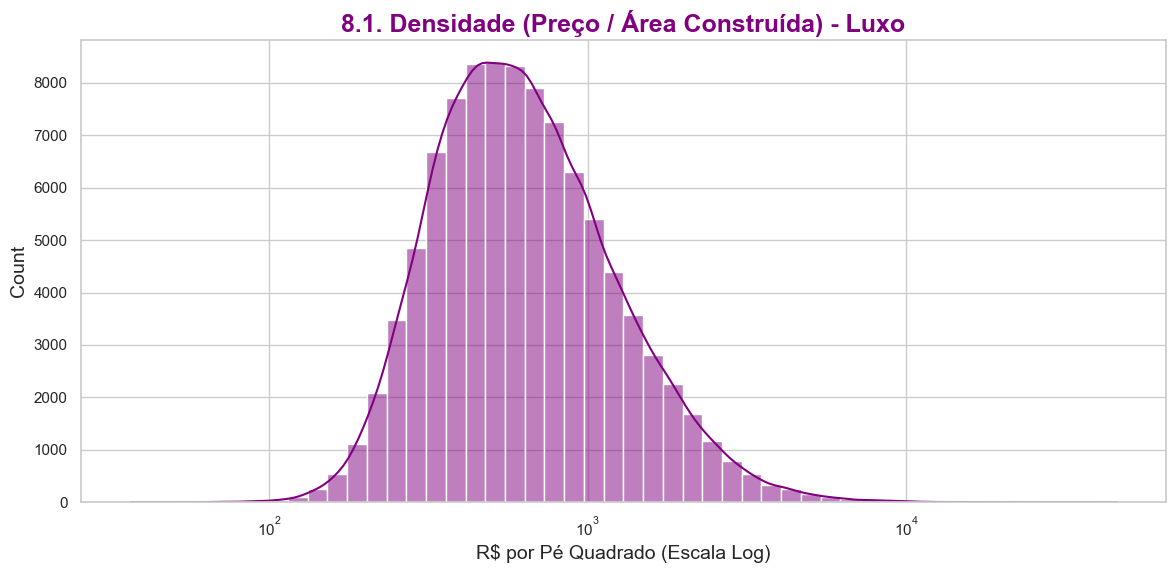

In [61]:
# --- GRÁFICO 8.1: Preço por Área (LUXO) ---
plt.figure(figsize=(14, 6))
mask_l = df_luxo['area_construida'] > 0
pp_sqft_l = df_luxo.loc[mask_l, 'preco'] / df_luxo.loc[mask_l, 'area_construida']

sns.histplot(pp_sqft_l, bins=50, log_scale=True, color='purple', kde=True)
plt.title('8.1. Densidade (Preço / Área Construída) - Luxo', fontweight='bold', color='purple')
plt.xlabel('R$ por Pé Quadrado (Escala Log)')
plt.show()

## 9. Top Imobiliárias (Market Share)
Quem domina o mercado?
* Analisamos a coluna `imobiliaria` para ver quais empresas têm o maior portfólio no banco de dados limpo.

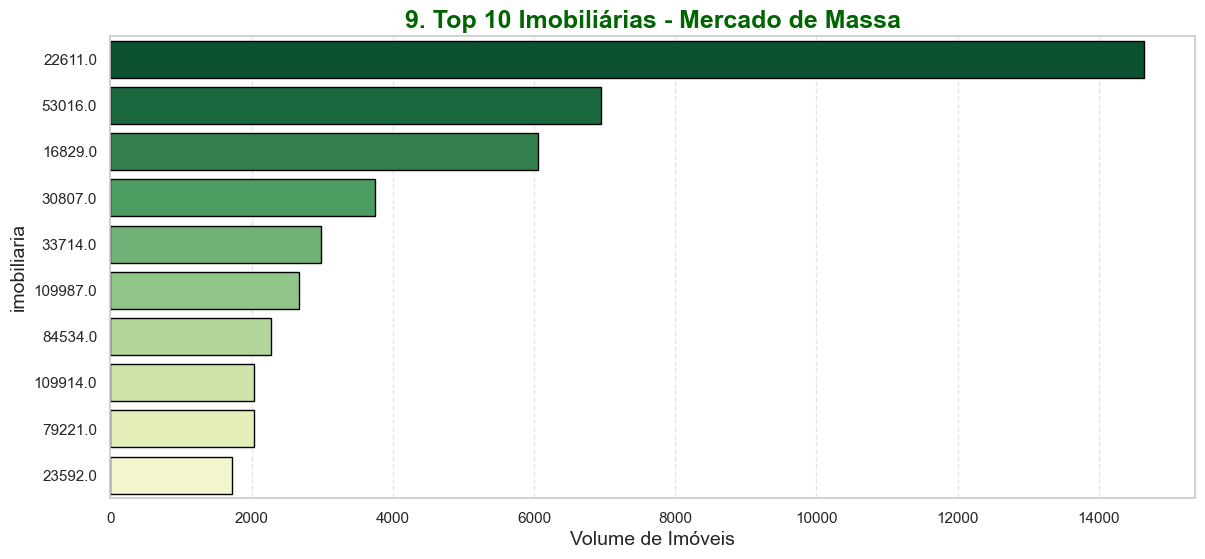

In [62]:
# --- GRÁFICO 9: Top Imobiliárias (MERCADO PADRÃO) ---
plt.figure(figsize=(14, 6))

# Dados
top_imob_p = df_padrao['imobiliaria'].value_counts().head(10)

# Correções: hue, legend=False, _=
# Visual: Paleta 'YlGn_r' (Verde Intenso -> Claro) e bordas pretas
_ = sns.barplot(
    x=top_imob_p.values, 
    y=top_imob_p.index, 
    hue=top_imob_p.index, 
    palette='YlGn_r', 
    edgecolor='black',
    legend=False
)

plt.title('9. Top 10 Imobiliárias - Mercado de Massa', fontweight='bold', color='darkgreen')
plt.xlabel('Volume de Imóveis')
plt.grid(axis='x', linestyle='--', alpha=0.5) # Grid vertical ajuda a ler o tamanho da barra
plt.show()

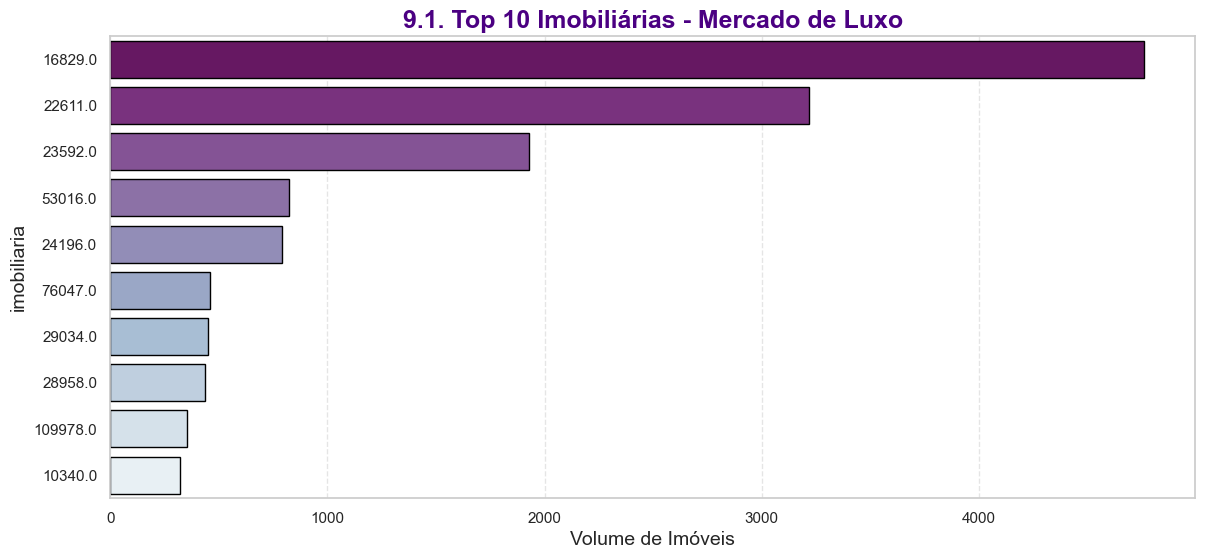

In [63]:
# --- GRÁFICO 9.1: Top Imobiliárias (MERCADO DE LUXO) ---
plt.figure(figsize=(14, 6))

top_imob_l = df_luxo['imobiliaria'].value_counts().head(10)

_ = sns.barplot(
    x=top_imob_l.values, 
    y=top_imob_l.index, 
    hue=top_imob_l.index,
    palette='BuPu_r',  # Roxo Intenso -> Claro
    edgecolor='black',
    legend=False
)

plt.title('9.1. Top 10 Imobiliárias - Mercado de Luxo', fontweight='bold', color='indigo')
plt.xlabel('Volume de Imóveis')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## 10. CEPs Mais Valorizados (Golden Zip Codes)
Identificamos os códigos postais (`cep`) com a maior mediana de preço.
* Isso revela os bairros mais ricos de cada segmento.

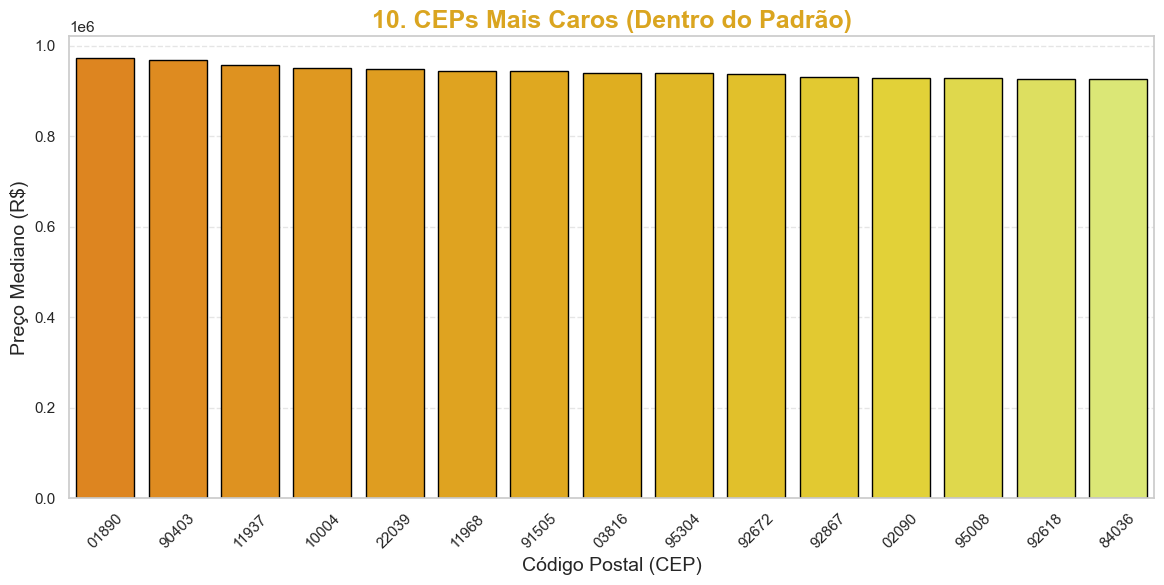

In [64]:
# --- GRÁFICO 10: CEPs Mais Caros (MERCADO PADRÃO) ---
plt.figure(figsize=(14, 6))

# 1. Filtro: CEPs com pelo menos 10 vendas (Relevância Estatística)
ceps_p = df_padrao['cep'].value_counts()
valid_ceps_p = ceps_p[ceps_p > 10].index

# 2. Cálculo da Mediana
wealth_p = df_padrao[df_padrao['cep'].isin(valid_ceps_p)].groupby('cep')['preco'].median().sort_values(ascending=False).head(15)

# 3. Plotagem Refinada
_ = sns.barplot(
    x=wealth_p.index, 
    y=wealth_p.values, 
    hue=wealth_p.index,    # Corrige o Warning
    palette='Wistia_r',    # Tons de Ouro
    edgecolor='black',     # Borda para definição
    legend=False
)

plt.title('10. CEPs Mais Caros (Dentro do Padrão)', fontweight='bold', color='goldenrod')
plt.ylabel('Preço Mediano (R$)')
plt.xlabel('Código Postal (CEP)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5) # Grid horizontal leve
plt.show()

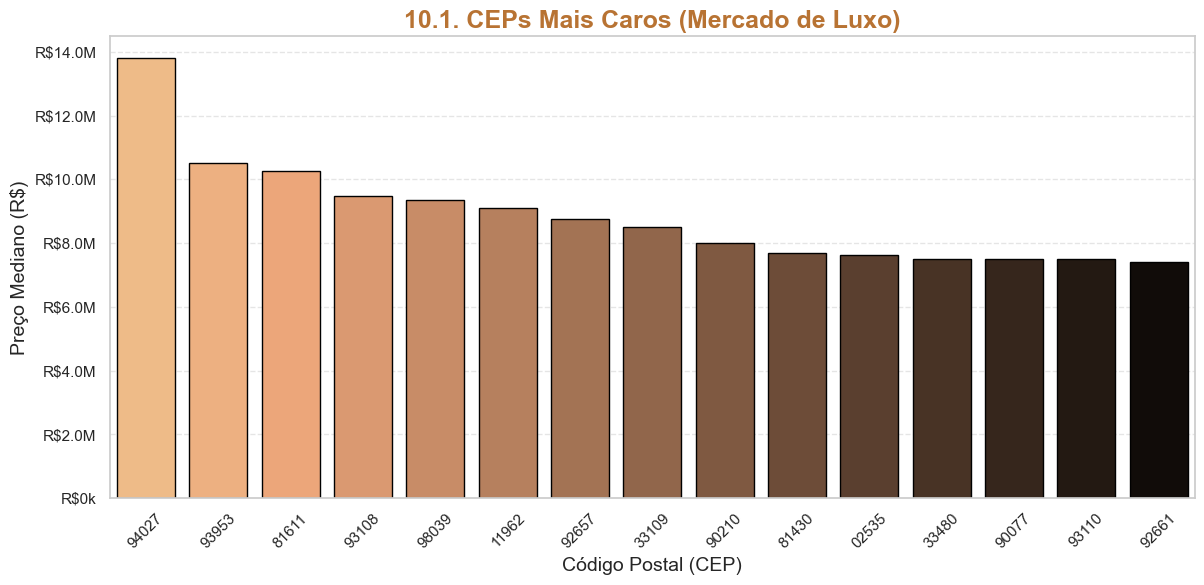

In [65]:
# --- GRÁFICO 10.1: CEPs Mais Caros (MERCADO DE LUXO) ---
plt.figure(figsize=(14, 6))

# Filtro menor (5) pois Luxo tem menos volume
ceps_l = df_luxo['cep'].value_counts()
valid_ceps_l = ceps_l[ceps_l > 5].index 

wealth_l = df_luxo[df_luxo['cep'].isin(valid_ceps_l)].groupby('cep')['preco'].median().sort_values(ascending=False).head(15)

_ = sns.barplot(
    x=wealth_l.index, 
    y=wealth_l.values, 
    hue=wealth_l.index,
    palette='copper_r',     # 'Copper' (Cobre) dá um tom metálico premium
    edgecolor='black',
    legend=False
)

plt.title('10.1. CEPs Mais Caros (Mercado de Luxo)', fontweight='bold', color='#B87333') # Cor Cobre
plt.ylabel('Preço Mediano (R$)')
plt.xlabel('Código Postal (CEP)')
plt.xticks(rotation=45)

# Formata eixo Y para Milhões
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

## 11. Volume por Estado (Ranking Geográfico)
Originalmente este gráfico mostrava "Dados Faltantes". Como nossa base Silver está limpa, agora usamos este espaço para mostrar **Onde estão os imóveis**.
* Mostra a distribuição geográfica do nosso dataset limpo.

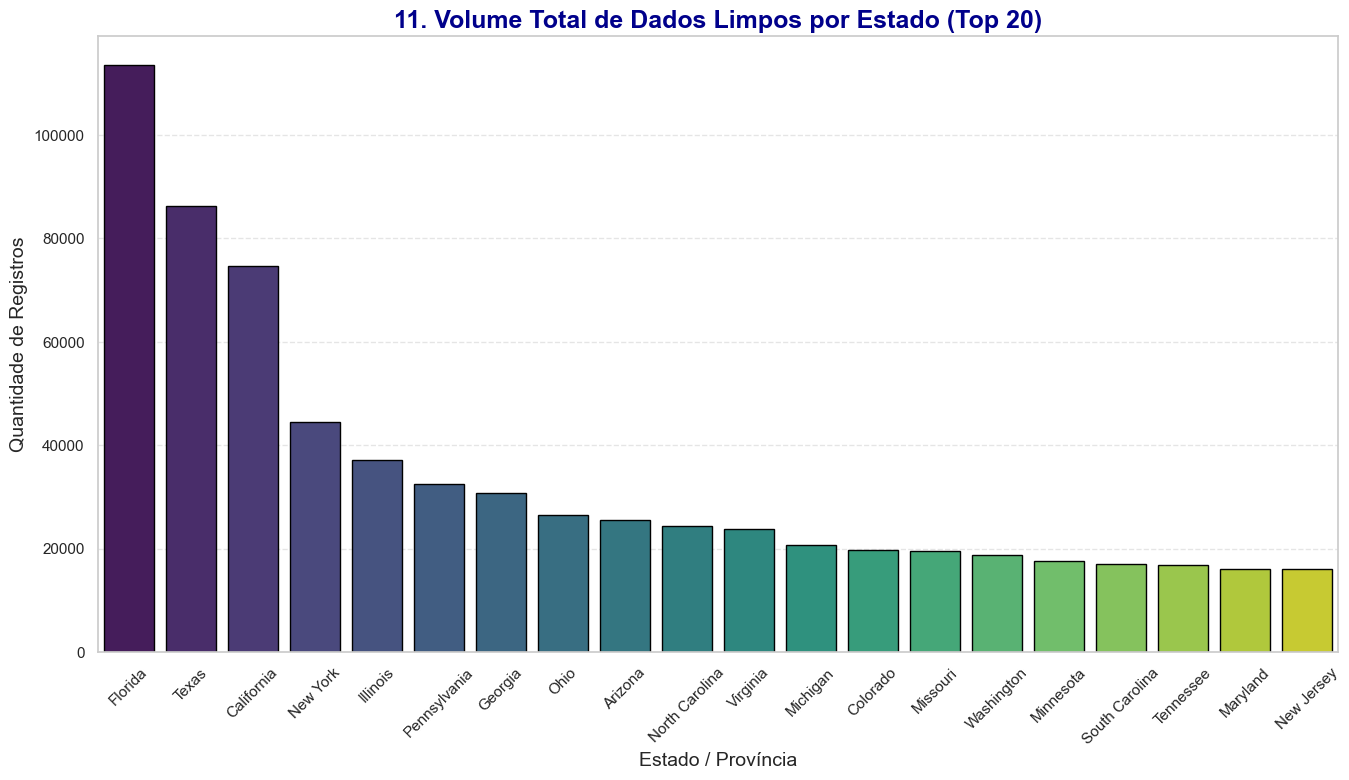

In [66]:
# --- GRÁFICO 11: Volume Geográfico (Visão Geral do Data Lakehouse) ---
plt.figure(figsize=(16, 8))

# Dados consolidados da tabela Silver
volume_estado = df_silver['estado'].value_counts().head(20)

# Plotagem Profissional
_ = sns.barplot(
    x=volume_estado.index, 
    y=volume_estado.values, 
    hue=volume_estado.index, # Correção do Warning
    palette='viridis',       # Paleta profissional para dados gerais
    edgecolor='black',       # Definição visual
    legend=False
)

plt.title('11. Volume Total de Dados Limpos por Estado (Top 20)', fontweight='bold', color='darkblue')
plt.xlabel('Estado / Província')
plt.ylabel('Quantidade de Registros')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5) # Grid ajuda a ver a escala
plt.show()

## 12. Boxplot Normalizado (Validação de Outliers)
Este é o teste final de limpeza. No Raw, este gráfico estava "achatado" por causa dos erros.
Agora, as caixas devem estar visíveis e distribuídas, provando que a variância estatística é real e saudável.

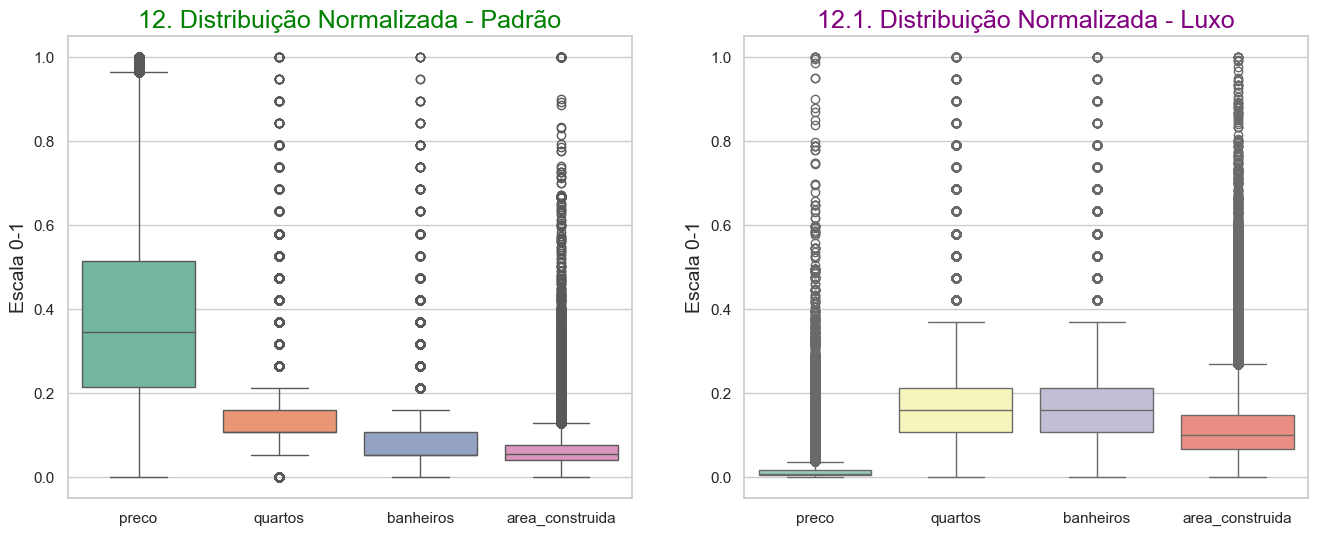

In [67]:
# --- GRÁFICO 13: Comparação Normalizada ---
# Normalização Min-Max apenas para visualização conjunta
df_num_p = df_padrao[['preco', 'quartos', 'banheiros', 'area_construida']].dropna()
df_norm_p = (df_num_p - df_num_p.min()) / (df_num_p.max() - df_num_p.min())

df_num_l = df_luxo[['preco', 'quartos', 'banheiros', 'area_construida']].dropna()
df_norm_l = (df_num_l - df_num_l.min()) / (df_num_l.max() - df_num_l.min())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df_norm_p, palette="Set2", ax=axes[0])
axes[0].set_title('12. Distribuição Normalizada - Padrão', color='green')
axes[0].set_ylabel('Escala 0-1')

sns.boxplot(data=df_norm_l, palette="Set3", ax=axes[1])
axes[1].set_title('12.1. Distribuição Normalizada - Luxo', color='purple')
axes[1].set_ylabel('Escala 0-1')

plt.show()

## 13. Integridade dos Dados (Zero Nulos)
O teste de ouro. O gráfico deve estar **totalmente cinza** (indicando dado presente).
Se houver listras coloridas, significa que temos nulos. Se estiver limpo, temos o "Silver de Ouro".

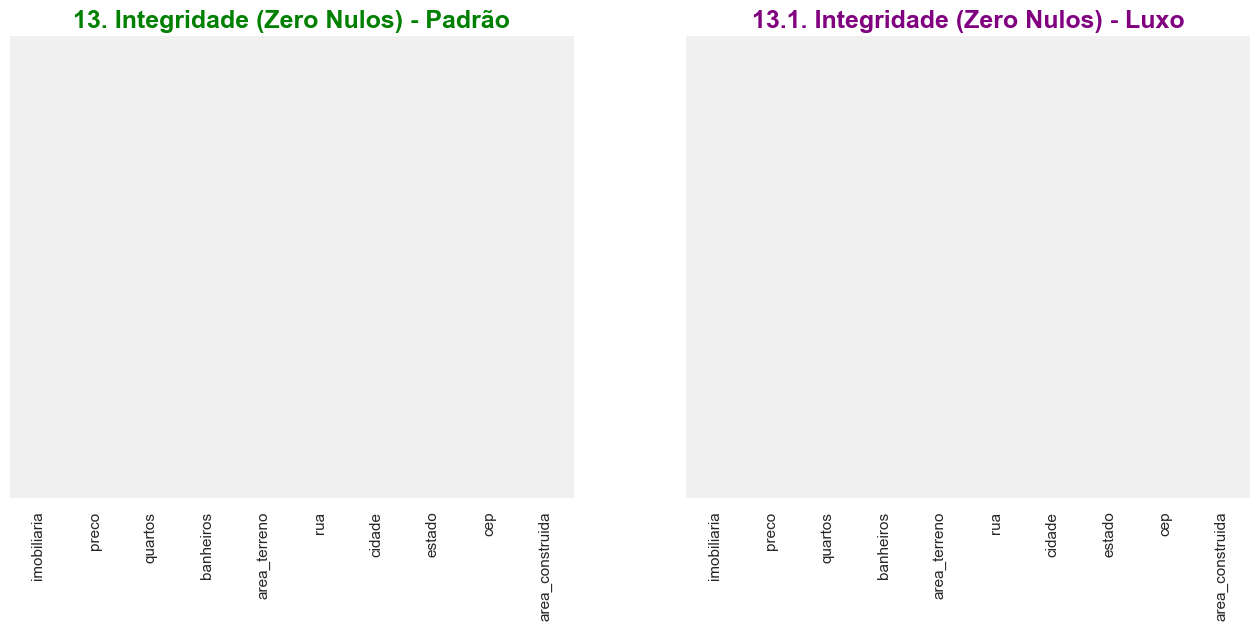

In [68]:

# Cores: Cinza Claro (Dado Existe) e Cor Forte (Nulo)
cmap_p = ListedColormap(['#F0F0F0', 'green'])
cmap_l = ListedColormap(['#F0F0F0', 'purple'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Padrão
sns.heatmap(df_padrao.isnull(), cbar=False, yticklabels=False, cmap=cmap_p, ax=axes[0], vmin=0, vmax=1)
axes[0].set_title('13. Integridade (Zero Nulos) - Padrão', fontweight='bold', color='green')

# Luxo
sns.heatmap(df_luxo.isnull(), cbar=False, yticklabels=False, cmap=cmap_l, ax=axes[1], vmin=0, vmax=1)
axes[1].set_title('13.1. Integridade (Zero Nulos) - Luxo', fontweight='bold', color='purple')

plt.show()

## 14. Correlações Finais (Pairplot)
Uma visão geral de como as variáveis interagem no dataset limpo. Ideal para identificar padrões para Machine Learning.

🕷️ Gerando Pairplot PADRÃO...


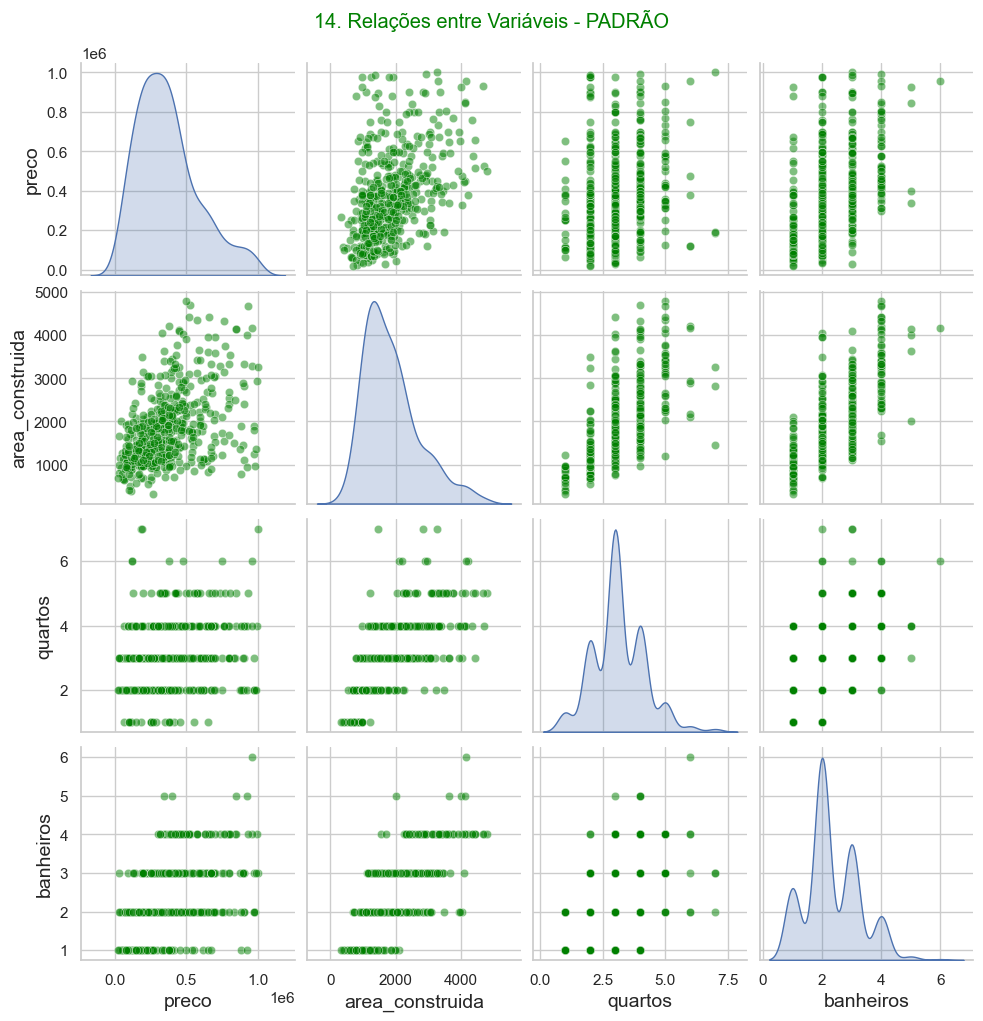

🕷️ Gerando Pairplot LUXO...


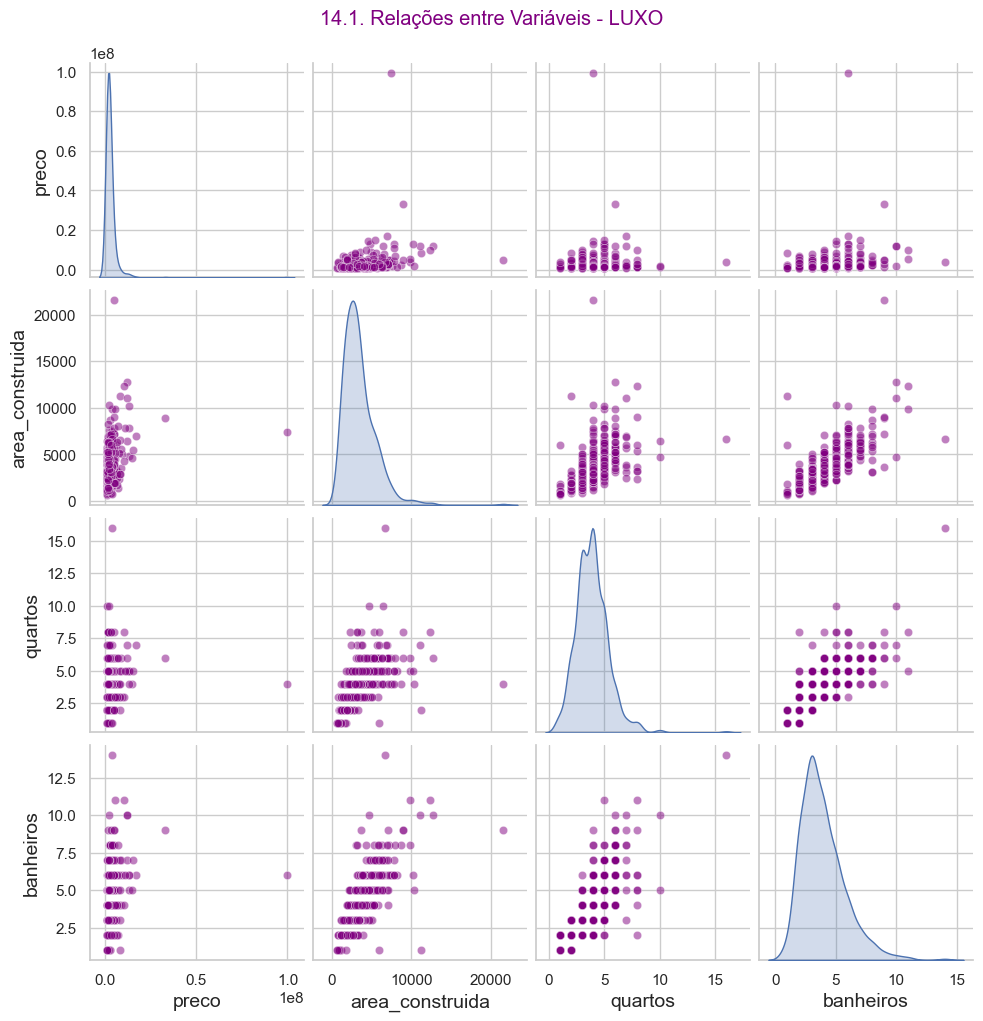

In [69]:
# --- GRÁFICO 15: Pairplots ---
cols_spider = ['preco', 'area_construida', 'quartos', 'banheiros']

print("🕷️ Gerando Pairplot PADRÃO...")
g = sns.pairplot(df_padrao[cols_spider].sample(500), diag_kind='kde', plot_kws={'alpha': 0.5, 'color': 'green'})
g.fig.suptitle("14. Relações entre Variáveis - PADRÃO", y=1.02, color='green')
plt.show()

print("🕷️ Gerando Pairplot LUXO...")
g = sns.pairplot(df_luxo[cols_spider].sample(500), diag_kind='kde', plot_kws={'alpha': 0.5, 'color': 'purple'})
g.fig.suptitle("14.1. Relações entre Variáveis - LUXO", y=1.02, color='purple')
plt.show()